<center><h1>Biometric Authentication</h1><h5>by Rebecca Hinrichs</h5><h5>∙ a discussion with examples ∙</h5><h5>FALL 2023</h5></center>

--- 
---

--- 

<center>We're using the Histogram of Gradients (HOG) feature detector integrated with a Support Vector Machines (SVM) model to classify 'Spoof vs Live Fingerprint' of the `Spoof_data` available <a href="https://drive.google.com/file/d/13wy8HhImW4cofOGciLfFZ5rXiRBxyEOC/view?usp=drive_link">here</a>.  

<hr style="width: 50%; border-color: black;"></center><br>

<h2>HoG Feature Detector</h2>

In [2]:
# # Extract the .7z file
# !pip install py7zr

In [4]:
# Load image directories from the zipped (.7z) file folder
import py7zr

working_directory = "C:\\Users\\beanl\\Downloads\\temp"
filename = "fingerprints_data.7z"
output_dir    = "Spoof_data"

with py7zr.SevenZipFile(working_directory+"\\"+filename, mode='r') as archive:
    archive.extractall(path=output_dir)

print(f"All files extracted to {working_directory+"\\"+output_dir}")

All files extracted to C:\Users\beanl\Downloads\temp\Spoof_data


In [20]:
# !pip install opencv-python
# !pip install scikit-learn
# !pip install scikit-image


Shape of the sample image: (372, 312, 3)



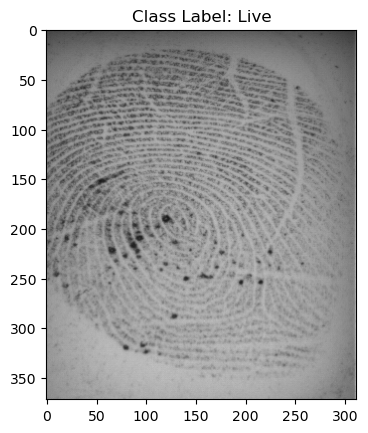

In [21]:
# Import ML libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load each image per subdirectory & assign its class label with its directory name
def load_images_with_labels(base_directory, target_size=(224, 224)):
    images, labels = list(), list()
    class_labels = os.listdir(base_directory)
    for label in class_labels:
        path = os.path.join(base_directory, label)
        if os.path.isdir(path):
            for img_file in os.listdir(path):
                img_path = os.path.join(path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # or cv2.IMREAD_GRAYSCALE
                if img is not None:
                    # img = cv2.resize(img, target_size) # ensure images are same size for model training
                    images.append(img)
                    labels.append(label)
    return images, labels

# Import the images & associated class labels
train_images, train_labels = load_images_with_labels(working_directory+"\\"+output_dir+"\\"+output_dir+'\\Training')

# Vectorize the class labels to class tensors
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_classes = encoder.fit_transform(train_labels)
# class_labels = encoder.inverse_transform(classes)  # de-vectorize tensors → strings

# Demonstrate a random sample image & its class label
import random
sample_index = random.randint(0, len(train_images) - 1)
sample_image, sample_label = train_images[sample_index], train_labels[sample_index]

# Since both HOG and LBP work faster with resized images, we'll do that now
from skimage.transform import resize
train_images = [resize(train_image, (128*4, 64*4)) for train_image in train_images]
resized_sample_image = resize(sample_image, (128*4, 64*4))

# Print the shape of the sample image
print(f"\nShape of the sample image: {sample_image.shape}\n")

# Display the sample image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title(f"Class Label: {sample_label}")
plt.show();

The HoG process:
  1. Import the image
  2. Resize the image
  3. Collect HOG features
  4. Pass features to classifier

We'll collect the HoG features of the images and display our sample image's HoG feature map.

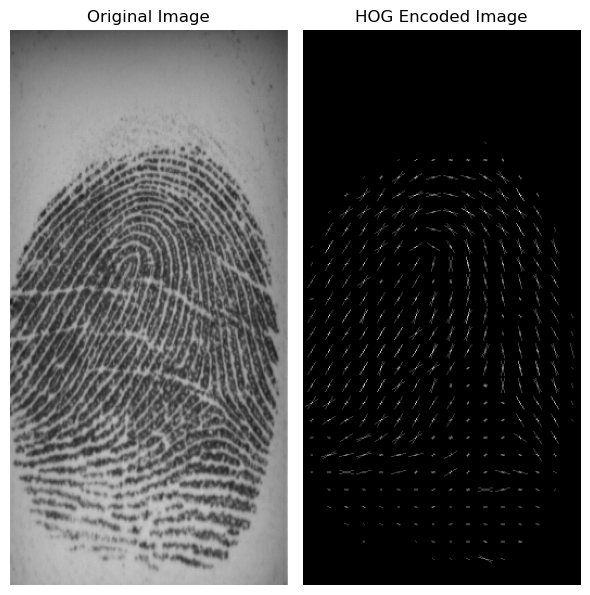

In [5]:
# Import ML Dependencies
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import io, feature, exposure
from skimage.feature import hog

# Function to process an image using HoG
def get_hog_features(images):
    hog_features, hog_images = [], []
    for image in images:
        features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                  cells_per_block=(1, 1), visualize=True, channel_axis=-1)
        hog_features.append(features)
        hog_images.append(hog_image)
    return hog_features, hog_images

# Get HoG features for all imported images
train_features, train_hog_images = get_hog_features(train_images)

# Demonstrate HoG features of the sample image
sample_features, sample_hog_image = hog(resized_sample_image, orientations=8, pixels_per_cell=(16, 16),
                                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)
sample_hog_image_rescaled = exposure.rescale_intensity(sample_hog_image, in_range=(0, 10))

# Plot the original and HOG images
plt.figure(figsize=(6,6))
plt.subplot(121), plt.imshow((resized_sample_image*255).astype(np.uint8), cmap='gray')
plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow((sample_hog_image_rescaled*255).astype(np.uint8), cmap='gray')
plt.title('HOG Encoded Image'), plt.axis('off')
plt.tight_layout(), plt.show();

Now we'll implement the SVM classification model on the training images.

In [6]:
# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, 
                                                    test_size=0.2, random_state=42)
# Train the SVM model classifier
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

# Evaluate the model's performance
from sklearn.metrics import classification_report, accuracy_score
y_pred = clf.predict(X_test)
print(f"Classification report:\n{classification_report(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Classification report:
              precision    recall  f1-score   support

        Live       0.95      0.85      0.90        47
       Spoof       0.82      0.94      0.88        35

    accuracy                           0.89        82
   macro avg       0.89      0.90      0.89        82
weighted avg       0.90      0.89      0.89        82

Accuracy: 0.8902439024390244


Now we'll implement this model on our testing images and report accuracy.

Classification Report:
              precision    recall  f1-score   support

        Live       0.89      0.56      0.68       200
       Spoof       0.68      0.93      0.78       200

    accuracy                           0.74       400
   macro avg       0.78      0.74      0.73       400
weighted avg       0.78      0.74      0.73       400

Accuracy: 0.7425



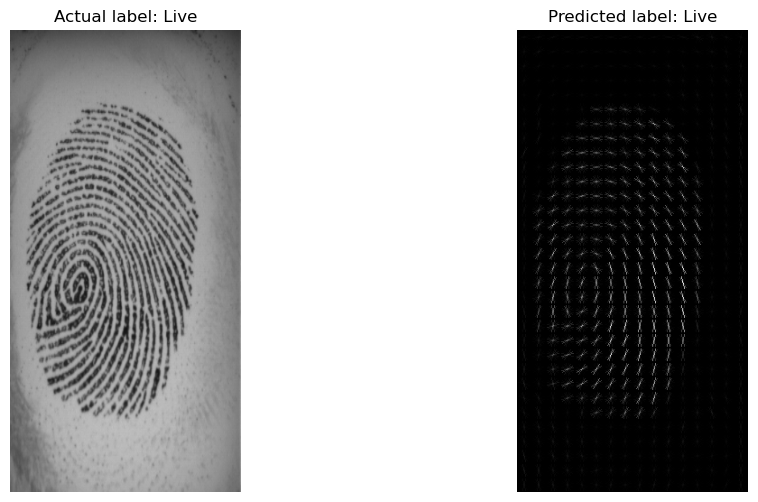

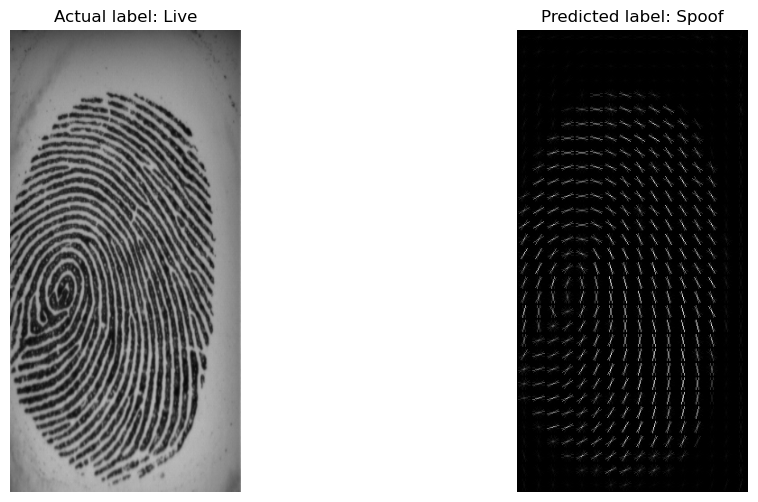

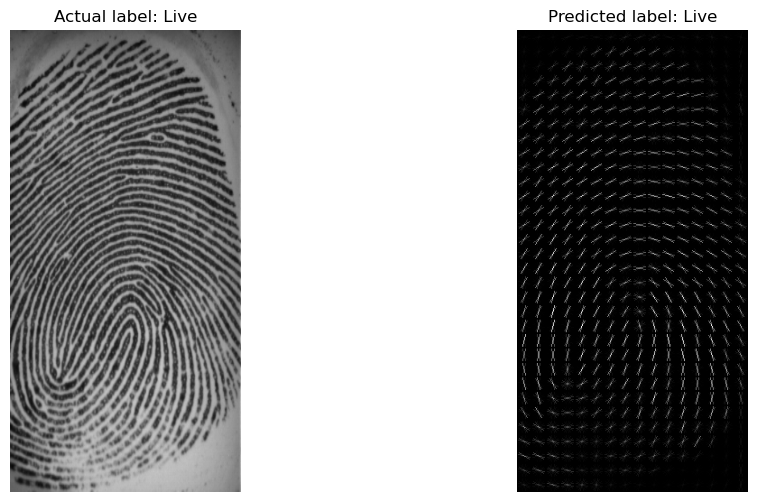

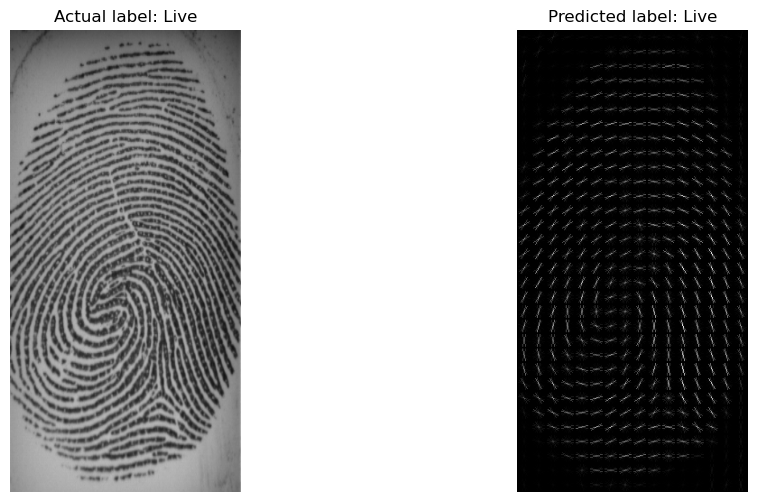

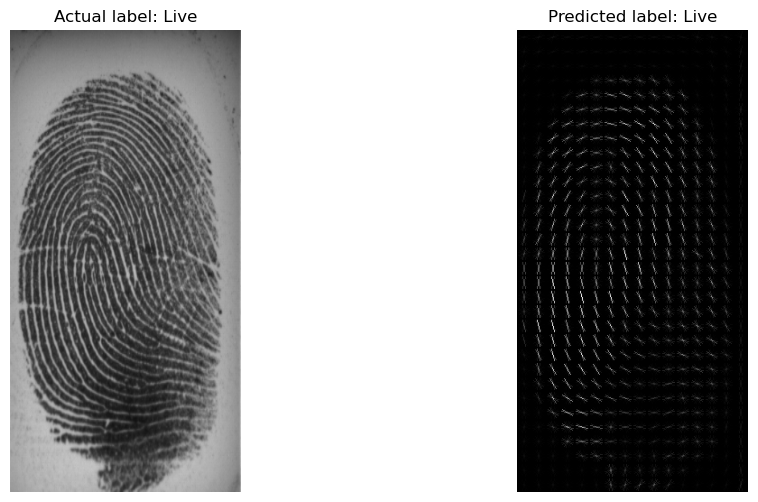

In [7]:
# Import the test images & associated class labels
test_images, test_labels = load_images_with_labels(working_directory+'\\Spoof_data\\Testing')
test_images = [resize(test_image, (128*4, 64*4)) for test_image in test_images] # resize the images
test_features, test_hog_images = get_hog_features(test_images)  # get HoG features for all imported images
test_pred = clf.predict(test_features)            # evaluate the model's performance
print(f"Classification Report:\n{classification_report(test_labels, test_pred)}")
print(f"Accuracy: {accuracy_score(test_labels, test_pred)}\n")

# Display a few test images along with their predicted labels
random_indices = random.sample(range(int(len(test_images))), 5)
for i in random_indices:
    image_rescaled = exposure.rescale_intensity(test_images[i], in_range=(0, 10))
    _, hog_image = hog(test_images[i], orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(cv2.cvtColor((test_images[i]*255).astype(np.uint8),cv2.COLOR_BGR2RGB))
    plt.title(f"Actual label: {test_labels[i]}"), plt.axis('off')
    plt.subplot(122), plt.imshow((hog_image_rescaled*255), cmap='gray')
    plt.title(f"Predicted label: {test_pred[i]}"), plt.axis('off')
    plt.show();

--- 

2.	Use the LBP feature with SVM to classify the 'Spoof vs Live Fingerprint' of the `Spoof_data` that is uploaded (Training Dataset + Testing Dataset). (50)

<center><hr style="width: 50%; border-color: black;"></center><br>

In [8]:
# # Clear the environment variables to prevent data leakage
# def clear_all():
#     for name in dir():
#         if not name.startswith('_'):
#             del globals()[name]
# clear_all()

In [9]:
# Re-import image files from scratch (& we actually didn't need to encode the labels)
train_images, train_labels = load_images_with_labels(working_directory+'\\Spoof_data\\Training')
train_images = [resize(train_image, (128*4, 64*4)) for train_image in train_images] # resize training images
test_images, test_labels = load_images_with_labels(working_directory+'\\Spoof_data\\Testing')
test_images = [resize(test_image, (128*4, 64*4)) for test_image in test_images] # resize testing images

<h2>LBP Feature Detector</h2>

The LBP process:
1. Import the image
2. Resize the image
3. Convert to grayscale
4. Collect LBP features
5. Normalize the features
6. Pass features to classifier

We'll collect the LBP features of the images and display our sample image's LBP feature map.

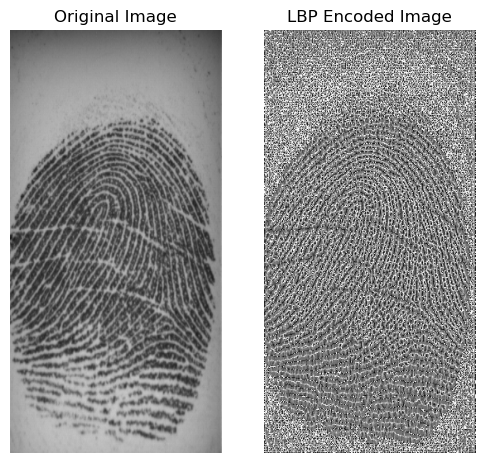

In [10]:
# Function to process an image using LBP
def get_lbp_features(images):
    lbp_features = []
    for image in images:
        # Convert to grayscale
        gray_image = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        # Extract LBP features
        lbp = feature.local_binary_pattern(gray_image, P=8, R=1, method='uniform')
        # Create a histogram of the LBP features
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_features.append(hist)
    return lbp_features

# Apply LBP operations to the images
train_features = get_lbp_features(train_images)
test_features = get_lbp_features(test_images)

# Demonstrate LBP features of the sample image
gray_lbp_image = cv2.cvtColor((resized_sample_image*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
sample_lbp = feature.local_binary_pattern(gray_lbp_image, P=8, R=1, method='uniform')
sample_lbp_image = (sample_lbp - sample_lbp.min()) / (sample_lbp.max() - sample_lbp.min())

# Plot the original and HOG images
plt.figure(figsize=(6, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor((resized_sample_image*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(sample_lbp_image, cmap='gray')
plt.title('LBP Encoded Image'), plt.axis('off')
plt.show();

Now we'll implement the SVM classification model on the training images.

In [11]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, 
                                                    test_size=0.2, random_state=42)
# Train the SVM model classifier
clf = svm.SVC()
clf.fit(X_train, y_train)

# Evaluate the model's performance
y_pred = clf.predict(X_test)
print(f"Classification report:\n{classification_report(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Classification report:
              precision    recall  f1-score   support

        Live       0.90      0.40      0.56        47
       Spoof       0.54      0.94      0.69        35

    accuracy                           0.63        82
   macro avg       0.72      0.67      0.62        82
weighted avg       0.75      0.63      0.61        82

Accuracy: 0.6341463414634146


Now we'll implement this model on our testing images and report accuracy.

Classification Report:
              precision    recall  f1-score   support

        Live       0.98      0.45      0.62       200
       Spoof       0.64      0.99      0.78       200

    accuracy                           0.72       400
   macro avg       0.81      0.72      0.70       400
weighted avg       0.81      0.72      0.70       400

Accuracy: 0.72



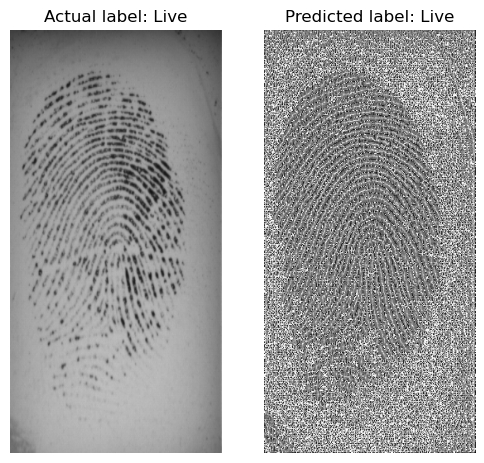

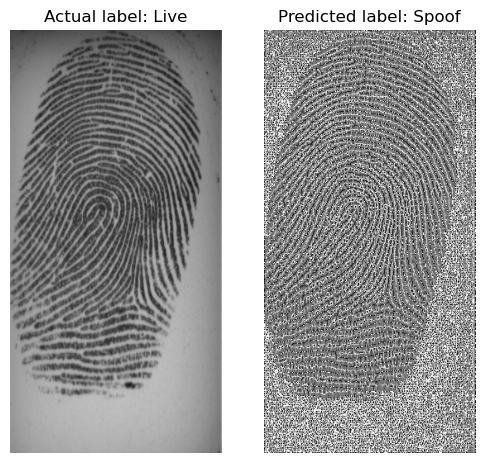

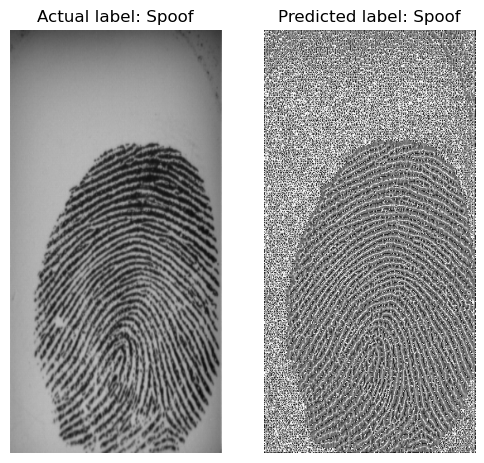

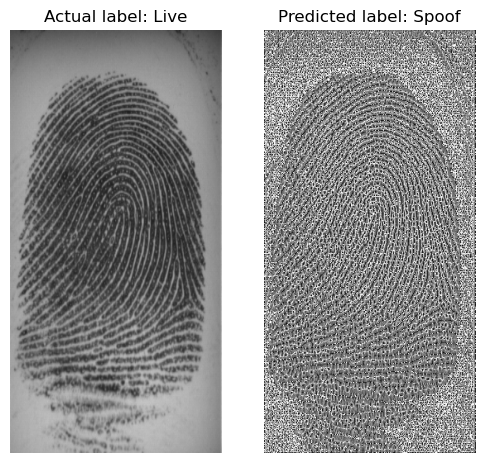

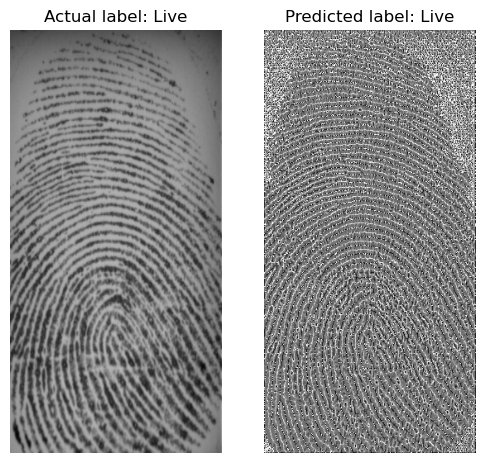

In [12]:
# Evaluate the model's performance
test_pred = clf.predict(test_features)
print(f"Classification Report:\n{classification_report(test_labels, test_pred)}")
print(f"Accuracy: {accuracy_score(test_labels, test_pred)}\n")

# Display a few test images along with their predicted labels
random_indices = random.sample(range(int(len(test_images))), 5)
for i in random_indices:
    gray_lbp = cv2.cvtColor((test_images[i]*255).astype(np.uint8), cv2.COLOR_BGR2GRAY) # grayscale
    lbp = feature.local_binary_pattern(gray_lbp, P=8, R=1, method='uniform')           # binarize
    lbp_image = (lbp - lbp.min()) / (lbp.max() - lbp.min())                            # normalize
    plt.figure(figsize=(6, 6))
    plt.subplot(121), plt.imshow(cv2.cvtColor((test_images[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f"Actual label: {test_labels[i]}"), plt.axis('off')
    plt.subplot(122), plt.imshow(lbp_image, cmap='gray')
    plt.title(f"Predicted label: {test_pred[i]}"), plt.axis('off')
    plt.show();

As we can see, the LBP model was much faster in processing the images, but less accurate in prediction & a bit more involved for the user in coding. But faster!

<br>

--- 

<center><i>Thank you!</i>

<hr style="width: 50%; border-color: black;"></center><br>